# Emotion Recognition with simple CNN

### Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

2025-12-12 22:09:15.189709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices("GPU"))

# Check if TensorFlow is using GPU
print("TensorFlow GPU:", tf.test.is_built_with_cuda())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU: True


### Dataset loading

In [3]:
# Load dataset
from keras.preprocessing import image_dataset_from_directory

cwd: str = os.getcwd()

train_dir: str = os.path.join(cwd, "../data/train")
test_dir: str = os.path.join(cwd, "../data/test")

batch_size: int = 64
img_size: tuple = (48, 48)
seed: int = 42

# Load training and validation datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"],
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"],
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"],
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1765570175.959088    1077 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:06:00.0, compute capability: 8.9


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Show one example image for each class from the training dataset

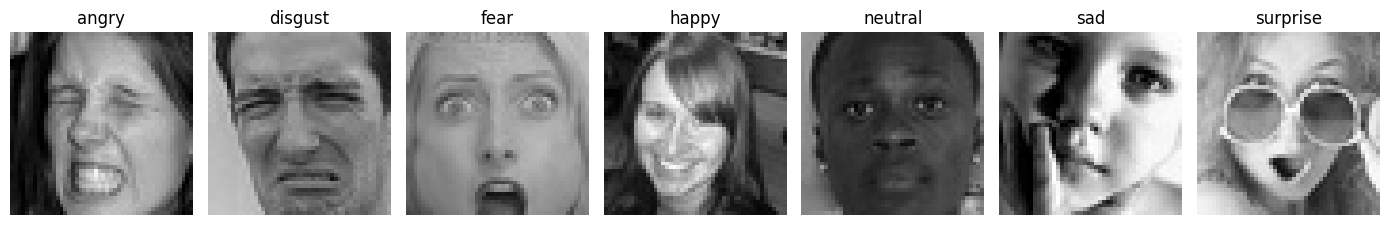

In [ ]:
class_names: list[str] = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
num_classes: int = len(class_names)

sample_images: list[None] = [None] * num_classes

# Collect one image per class
for img, label in train_dataset.unbatch():
    class_idx = int(tf.argmax(label).numpy())
    if sample_images[class_idx] is None:
        sample_images[class_idx] = img.numpy()
    if all(im is not None for im in sample_images):
        break

# Plot
plt.figure(figsize=(14, 3))
for i, (img, cname) in enumerate(zip(sample_images, class_names)):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(cname)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
def plot_class_distribution(dataset_dir, subset_name):
    """Plot the class distribution of the dataset"""
    class_count = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len(os.listdir(class_dir))
        class_count[class_name] = num_images

    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values())
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Class distribution" + " " + subset_name)
    plt.show()

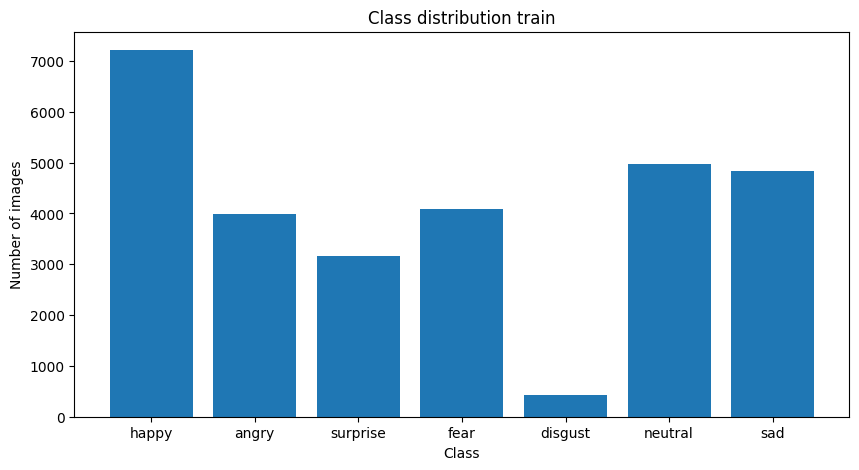

In [10]:
plot_class_distribution(train_dir, "train")

### Helper Classes and Functions

In [4]:
class DatasetPreparer:
    def __init__(self):
        self.data_augmentation = self._create_augmentation_pipeline()

    def _create_augmentation_pipeline(self):
        """Create the data augmentation pipeline"""
        return keras.Sequential(
            [
                keras.layers.RandomFlip(
                    "horizontal_and_vertical"
                ),
                keras.layers.RandomRotation(0.1),
            ]
        )

    def preprocess_image(self, image, is_gray=True):
        """Convert image to grayscale float32 and normalize"""
        if is_gray:
            image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.float32)  # scales to [0, 1]
        return image

    def augment_and_preprocess(self, image, augment):
        """Apply data augmentation and preprocess the image"""
        if augment:
            image = self.data_augmentation(image)
        return self.preprocess_image(image)

    def prepare_dataset(self, dataset, augment=False):
        """Prepare a single dataset split for training"""
        dataset = dataset.map(
            lambda x, y: (self.augment_and_preprocess(x, augment), y),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset


In [5]:
def plot_history(history) -> None:
    """Function to plot the training and validation history"""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()


In [ ]:
def metrics(model, class_names, test_ds):
    """Function to calculate the metrics of the model"""
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {test_accuracy}")
    print("\n")

    # Make predictions
    predictions = model.predict(test_ds)
    y_pred = np.argmax(predictions, axis=1)

    # Get the true labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Print classification report
    from sklearn.metrics import classification_report

    print(classification_report(y_true, y_pred))

    # Generate confusion matrix
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [31]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Any, Dict, List, Union, Iterable


def _compute_multi_class_weights(y: np.ndarray) -> Dict[int, float]:
    """
    Computes class weights for standard multi-class classification.
    Assumes y is a flat array of labels (strings or ints).
    """
    # np.unique sorts labels alphanumerically, matching Keras's default indexing
    classes = np.unique(y)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)

    # Keras requires integer keys corresponding to class indices (0, 1, 2...)
    return {i: w for i, w in enumerate(weights)}


def _compute_multi_label_weights(y: np.ndarray) -> Dict[int, float]:
    """
    Computes class weights for multi-label classification using frequency balancing.
    Assumes y is one-hot encoded.
    """
    n_samples = len(y)
    n_classes = len(y[0])

    # Summing columns gives total occurrences per class
    class_counts = y.sum(axis=0)

    # balanced formula: n_samples / (n_classes * count)
    weights = [
        n_samples / (n_classes * count) if count > 0 else 1.0 for count in class_counts
    ]

    return {i: w for i, w in enumerate(weights)}


def generate_class_weights(
    class_series: Union[List[Any], np.ndarray],
    multi_class: bool = True,
    one_hot_encoded: bool = False,
) -> Dict[int, float]:
    """
    Generates class weights for Keras models.

    Args:
        class_series: The target labels (list of strings, ints, or one-hot arrays).
        multi_class: True for single-label (categorical), False for multi-label.
        one_hot_encoded: True if inputs are already OHE.

    Returns:
        Dict[int, float]: A dictionary mapping class indices (0, 1...) to weights.
    """
    if multi_class:
        if one_hot_encoded:
            y = np.argmax(class_series, axis=1)
        else:
            y = np.array(class_series)
        return _compute_multi_class_weights(y)

    # Handle Multi-label
    if not one_hot_encoded:
        mlb = MultiLabelBinarizer()
        y = mlb.fit_transform(class_series)
    else:
        y = np.array(class_series)

    return _compute_multi_label_weights(y)


### Model Creation

In [9]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=True)
validation_ds = dataset_preparer.prepare_dataset(validation_dataset, augment=True)
test_ds = dataset_preparer.prepare_dataset(test_dataset, augment=False)

In [18]:
from keras import layers

class DenseBlock(layers.Layer):
    """
    Implements the "Dense" connectivity described in the paper,
    where layers are directly connected to all subsequent layers.
    """

    def __init__(self, growth_rate, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.conv_layers = []
        self.concat = layers.Concatenate()

        for _ in range(num_layers):
            # The paper mentions extracting features progressively
            # We use standard DenseNet composition: BN -> ReLU -> Conv
            self.conv_layers.append(
                keras.Sequential(
                    [
                        layers.BatchNormalization(),
                        layers.Activation("relu"),
                        layers.Conv2D(
                            growth_rate, (3, 3), padding="same", use_bias=False
                        ),
                    ]
                )
            )

    def call(self, inputs):
        x = inputs
        features = [x]

        for i in range(self.num_layers):
            # Input to layer i is the concatenation of all previous outputs
            layer_input = self.concat(features)
            output = self.conv_layers[i](layer_input)
            features.append(output)

        return self.concat(features)


class TransitionLayer(layers.Layer):
    """
    Implements the 1x1 convolution for feature map fusion and dimensionality
    reduction mentioned in the paper.
    """

    def __init__(self, reduction_filters):
        super().__init__()
        self.conv1x1 = layers.Conv2D(
            reduction_filters, (1, 1), padding="same", use_bias=False
        )
        self.pool = layers.MaxPooling2D((2, 2))
        self.bn = layers.BatchNormalization()
        self.act = layers.Activation("relu")

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.act(x)
        x = self.conv1x1(x)  # 1x1 Fusion
        return self.pool(x)


class DNET(keras.Model):
    def __init__(self, num_classes=7):
        super().__init__()

        # Initial Convolution [cite: 104]
        self.conv_initial = layers.Conv2D(
            64, (7, 7), strides=2, padding="same", use_bias=False
        )
        self.bn_initial = layers.BatchNormalization()
        self.act_initial = layers.Activation("relu")
        self.pool_initial = layers.MaxPooling2D((3, 3), strides=2, padding="same")

        # Dense Blocks (The "DNET" core)
        # The paper mentions "first two layers" and "last two layers" having different roles.
        # We simulate this with 2 dense blocks.
        self.dense_block1 = DenseBlock(growth_rate=32, num_layers=4)
        self.transition1 = TransitionLayer(reduction_filters=64)  # 1x1 Conv fusion

        self.dense_block2 = DenseBlock(growth_rate=32, num_layers=4)
        self.transition2 = TransitionLayer(reduction_filters=64)

        # Classification Head (Multilayer Perceptron)
        self.global_pool = layers.GlobalAveragePooling2D()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(256, activation="relu")
        self.dropout = layers.Dropout(0.5)  # Commonly used in FER tasks
        self.output_layer = layers.Dense(num_classes, activation="softmax")

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        # 1. Initial Features
        x = self.conv_initial(inputs)
        x = self.bn_initial(x)
        x = self.act_initial(x)
        x = self.pool_initial(x)

        # 2. DNET Structure (Dense connections)
        x = self.dense_block1(x)
        x = self.transition1(x)  # Fusion

        x = self.dense_block2(x)
        x = self.transition2(x)

        # 3. MLP Classification
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)

        return self.output_layer(x)


# Input shape 48x48x1 (grayscale) for FER-2013, or 100x100x3 if following the paper strictly
model = DNET(num_classes=7)
model.build(input_shape=(None, 48, 48, 1))
model.summary()
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

Model: "dnet_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_6 (DenseBlock)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_6              │ ?                      │   0 (unbuilt) │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_7 (DenseBlock)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_7              │ ?                      │   0 (unbuilt) │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath=f"{cwd}/../model_checkpoints/dnet_best_model.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
]

In [32]:
class_weights = generate_class_weights(
    class_names, multi_class=True, one_hot_encoded=False
)
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0)}


In [24]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=validation_ds,
    callbacks=my_callbacks,
    class_weight=generate_class_weights(
        class_names, multi_class=True, one_hot_encoded=False
    ),
)

Epoch 1/100


2025-12-12 22:41:02.282004: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f93d0008230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-12 22:41:02.282085: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-12 22:41:02.505017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-12 22:41:03.076485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-12 22:41:03.180812: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 22:41:03.180877: I e

 13/359 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1423 - loss: 9.5962 

I0000 00:00:1765572071.459086    4312 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2304 - loss: 2.5768

2025-12-12 22:41:14.879386: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 22:41:14.879451: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 22:41:14.879464: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 22:41:15.204450: I external/l

RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InternalError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/framework/errors_impl.py(462): __init__
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/context.py(1688): call_function
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py(139): call_function
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(878): _call
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py(241): function
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py(399): fit
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py(117): error_handler
  /tmp/ipykernel_1077/766565854.py(1): <module>
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3579): run_code
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3519): run_ast_nodes
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3336): run_cell_async
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3132): _run_cell
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3077): run_cell
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py(663): run_cell
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py(458): do_execute
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py(827): execute_request
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py(366): execute_request
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py(471): dispatch_shell
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py(614): shell_main
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/utils.py(71): preserve_context
  /usr/lib/python3.10/asyncio/events.py(80): _run
  /usr/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /usr/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py(211): start
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py(758): start
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/ipykernel_launcher.py(18): <module>
  /usr/lib/python3.10/runpy.py(86): _run_code
  /usr/lib/python3.10/runpy.py(196): _run_module_as_main


In [ ]:
best_model = keras.models.load_model(f"{cwd}/../model_checkpoints/dnet_best_model.keras")

metrics(best_model, class_names, test_dataset)
